C:\Users\Marcio\AppData\Local\Temp\ipykernel_20904\1849971298.py:1: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, QAOA, SamplingVQE


Number of assets: 16


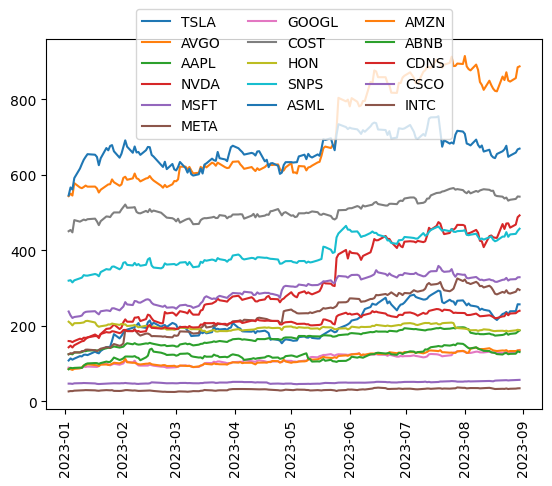

In [2]:
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import numpy as np
import matplotlib.pyplot as plt
import datetime
from qiskit_finance import QiskitFinanceError
from qiskit_finance.data_providers import *
from pandas.plotting import register_matplotlib_converters

# set number of assets (= number of qubits)
num_assets = 0
seed = 1234

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]

try:
    data = YahooDataProvider(
        tickers=['TSLA','AVGO','AAPL','NVDA','MSFT','META','GOOGL','COST','HON','SNPS','ASML','AMZN','ABNB','CDNS','CSCO','INTC'],
        start=datetime.datetime(2023, 1, 1),
        end=datetime.datetime(2023, 8, 31),

    )

    num_assets = len(data._tickers)
    print("Number of assets: {}".format(num_assets))

    data.run()
    for (cnt, s) in enumerate(data._tickers):
        plt.plot(data._data[cnt], label=s)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=3)
    plt.xticks(rotation=90)
    plt.show()
except QiskitFinanceError as ex:
    data = None
    print(ex)
#Returns a vector containing the mean value of each asset.
mu = data.get_period_return_mean_vector()
#Returns the covariance matrix.
sigma = data.get_period_return_covariance_matrix()



In [4]:
import seaborn as sns
#tickers=['AMZN', 'META', 'GOOGL', 'NVDA','AVGO','MSFT','AAPL','TSLA','ADBE','GOOG',],
tickers=['TSLA','AVGO','AAPL','NVDA','MSFT','META','GOOGL','COST','HON','SNPS','ASML','AMZN','ABNB','CDNS','CSCO','INTC'],
fig, ax = plt.subplots(figsize=(200,50))         # Sample figsize in inches
sns.heatmap(sigma, annot=True, linewidths=.5,fmt='g', xticklabels=tickers, yticklabels=tickers,ax=ax)

# plot sigma

#plt.imshow(sigma, interpolation="nearest")

plt.show()



In [5]:
q = 0.9  # set risk factor
budget = num_assets // 2  # set budget

#penalty = num_assets  # set parameter to scale the budget penalty term
penalty = num_assets  # set parameter to scale the budget penalty term

print("Budget: {}".format(budget))
print("Risk factor: {}".format(q))
print("Penalty: {}".format(penalty))
print("Expected return: {}".format(mu))
#print("Covariance: {}".format(sigma))
print("Number of assets: {}".format(num_assets))

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
print(qp.prettyprint(wrap=80))



Budget: 8
Risk factor: 0.9
Penalty: 16
Expected return: [ 0.00585905  0.00316744  0.00257346  0.00807569  0.00210797  0.00560737
  0.00275972  0.00119261 -0.00060409  0.00232595  0.00145689  0.00298579
  0.00300654  0.00263503  0.00124252  0.00198175]
Number of assets: 16
Problem name: Portfolio optimization

Minimize
  0.00109204941098198*x_0^2 + 0.0004441195858845842*x_0*x_1
  + 0.0005315405043533361*x_0*x_10 + 0.0005269330954243582*x_0*x_11
  + 0.0008134224870038617*x_0*x_12 + 0.0005122681173668281*x_0*x_13
  + 0.00017511478062723115*x_0*x_14 + 0.00038098306211341553*x_0*x_15
  + 0.0004056534544788845*x_0*x_2 + 0.0009168473446347107*x_0*x_3
  + 0.00037037818135073996*x_0*x_4 + 0.0006644805893782429*x_0*x_5
  + 0.00044547817089219186*x_0*x_6 + 0.00022529240963447368*x_0*x_7
  + 0.0001751478289567912*x_0*x_8 + 0.0004664581283182006*x_0*x_9
  + 0.0003583342621078095*x_1^2 + 0.0004451508927441143*x_1*x_10
  + 0.000244410873259759*x_1*x_11 + 0.0003255462539903194*x_1*x_12
  + 0.000346439

In [6]:
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

In [8]:
from qiskit.utils import algorithm_globals


from qiskit.visualization import *
cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ansatz = TwoLocal(num_assets, "ry", "cz", reps=3,  entanglement="full")
vqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ansatz, optimizer=cobyla)
vqe = MinimumEigenOptimizer(vqe_mes)
resultvqe = vqe.solve(qp)
#print_result(resultvqe)
#ansatz.decompose().draw('mpl')

    
#['AMZN', 'META', 'GOOGL', 'NVDA','AVGO','MSFT','AAPL','TSLA','ADBE',],
#Optimal: selection [0. 1. 0. 1. 1. 0. 0. 1. 0.], value -0.0189
#Optimal: selection [0. 1. 0. 1. 1. 0. 0. 1. 0.], value -0.0189
#Optimal: selection [0. 1. 0. 1. 0. 0. 1. 1. 0.], value -0.0186

In [9]:
algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3)
qaoa = MinimumEigenOptimizer(qaoa_mes)
resultqaoa = qaoa.solve(qp)

#print_result(resultqaoa)
#ansatz.decompose().draw('mpl')
#['AMZN', 'META', 'GOOGL', 'NVDA','AVGO','MSFT','AAPL','TSLA','ADBE',],

#Optimal: selection [1. 1. 1. 0. 1. 0. 0. 1. 0. 0.], value -0.0267

In [10]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)
print_result(resultvqe)
print_result(resultqaoa)

#tickers=['TSLA','AVGO','AAPL','NVDA','MSFT','META','GOOGL','COST','HON','SNPS','ASML','AMZN','ABNB','CDNS','CSCO','INTC'],

Optimal: selection [1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.], value -0.0175

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 1 1 1 0 1 0 1 0 0 0 1 0 0 1 0]	-0.0175		1.0000
Optimal: selection [1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0.], value -0.0174

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 1 1 0 1 0 0 0 0 0 0 1 1 1 0]	-0.0159		0.0039
[1 1 1 1 0 0 1 1 0 0 1 1 0 0 1 0]	-0.0138		0.0039
[1 1 0 0 0 1 1 1 1 0 1 1 0 0 1 0]	-0.0100		0.0029
[0 1 1 1 0 1 1 0 0 0 1 0 1 0 0 0]	-0.0142		0.0029
[1 1 1 0 0 0 1 0 1 0 0 1 0 0 1 0]	-0.0104		0.0029
[1 1 1 1 0 1 1 1 0 0 1 1 0 0 1 0]	-0.0147		0.0029
[1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1]	-0.0127		0.0020
[1 1 1 0 0 1 1 1 0 0 0 1 0 0 0 1]	-0.0129		0.0020
[0 1 1 1 0 1 1 0 0 0 0 1 1 0 1 0]	-0.0161		0.0020
[1 0 1 1 0 1 1 1 0 1 1 0 1 0 1 0]	-0.0134		0.0020
[0 1 1 1 0 1 1